### XGBoost for regression

In this lab, you'll apply XGBoost to the regression task of predicting house prices in Ames, Iowa. Along the way, you'll learn about the two kinds of base learners that XGboost can use as its weak learners, and review how to evaluate the quality of your regression models.

The outline:
<ol type='1'>
<li>Decision trees as base learners. Computing the rmse</li>
<li>Linear base learners boosted with gblinear. Computing the rmse</li>
<li>Evaluating model quality</li>
<li>Using regularization in XGBoost with l2 value</li>
<li>Visualizing individual XGBoost trees</li>
<li>Visualizing feature importances: What features are most important in my dataset</li>
</ol>

Before we get started, let's refresh our knowledge about the objective (loss) functions

Objective Functions:
<ul>
<li>Quantifies how far off a prediction is from the actual result</li>
<li>Measures the difference between estimated and true values for some collection of
data</li>
<li>Goal: Find the model that yields the minimum value of the loss function</li>
</ul>

<b>1. Decision trees as base learners. Computing the rmse</b>

Import the libs

In [31]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Import xgboost
import xgboost as xgb
# import the mean_squared_error from sklearn library
from sklearn.metrics import mean_squared_error

read the dataset

In [32]:
dataset = pd.read_csv('ames_housing_trimmed_processed.csv')

In [33]:
dataset.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,Remodeled,GrLivArea,BsmtFullBath,BsmtHalfBath,...,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,PavedDrive_P,PavedDrive_Y,SalePrice
0,60,65.0,8450,7,5,2003,0,1710,1,0,...,0,0,0,0,1,0,0,0,1,208500
1,20,80.0,9600,6,8,1976,0,1262,0,1,...,0,1,0,0,0,0,0,0,1,181500
2,60,68.0,11250,7,5,2001,1,1786,1,0,...,0,0,0,0,1,0,0,0,1,223500
3,70,60.0,9550,7,5,1915,1,1717,1,0,...,0,0,0,0,1,0,0,0,1,140000
4,60,84.0,14260,8,5,2000,0,2198,1,0,...,0,0,0,0,1,0,0,0,1,250000


Create arrays for the features and the target: X, y

In [34]:
# Create arrays for the features and the target: X, y
X = dataset.iloc[:, :-1]
y = dataset.iloc[:, -1]

Create the training and test sets. Set the random_state = 123

In [35]:
# Create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 123)

In this exercise, your goal is to use trees as base learners. By default, <u>XGBoost uses trees as base learners</u>, so you don't have to specify that you want to use trees here with <i>booster="gbtree"</i>.

Instantiate the XGBRegressor as <b>xg_reg</b>, using a seed of 123. Specify an objective of "reg:linear" and use 10 trees. Note: You don't have to specify booster="gbtree" as this is the default
(please refer to the <a href='https://xgboost.readthedocs.io/en/latest/python/python_api.html'>documentation</a>)

In [36]:
# Instantiate the XGBRegressor as xg_reg
xg_reg = xgb.XGBRegressor(seed=123, objective='reg:linear', n_estimators=10)

Fit xg_reg to the training data and predict the labels of the test set. Save the predictions in a variable called preds.

In [37]:
xg_reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=10,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
       silent=True, subsample=1)

Predict the labels of the test set: preds

In [38]:
preds = xg_reg.predict(X_test)

Compute the rmse using np.sqrt() and the mean_squared_error() function from sklearn.metrics, which has been pre-imported.

In [39]:
rmse = np.sqrt(mean_squared_error(y_test, preds))

In [40]:
print("RMSE: %f" % (rmse))

RMSE: 79631.978420


<b>2. Linear base learners</b>

Now that you've used trees as base models in XGBoost, let's use the other kind of base model that can be used with XGBoost - a linear learner. This model, although not as commonly used in XGBoost, allows you to create a regularized linear regression using XGBoost's powerful learning API. However, because it's uncommon, you have to use XGBoost's own non-scikit-learn compatible functions to build the model, such as xgb.train().

In order to do this you must create the parameter dictionary that describes the kind of booster you want to use (similarly to how you created the dictionary in the previous lab, when you used xgb.cv()). The key-value pair that defines the booster type (base model) you need can be found in the <a href='https://xgboost.readthedocs.io/en/latest/python/python_api.html'>documentation</a>. Which one do you need?

Once you've created the model, you can use the .train() and .predict() methods of the model just like you've done in the past.

Create two DMatrix objects - DM_train for the training set (X_train and y_train), and DM_test (X_test and y_test) for the test set.

In [41]:
DM_train = xgb.DMatrix(X_train, y_train)
DM_test =  xgb.DMatrix(X_test, y_test)

Create a parameter dictionary that defines the "booster" type you will use as well as the "objective" you will minimize ("reg:linear").

In [42]:
params = {'objective':'reg:linear', 'booster':'gbtree'}

Train the model using xgb.train(). You have to specify arguments for the following parameters: params, dtrain, and num_boost_round. Use 5 boosting rounds.

In [43]:
xg_reg = xgb.train(params = params, dtrain=DM_train, num_boost_round=5)

[01:32:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[01:32:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[01:32:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[01:32:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[01:32:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6


Predict the labels on the test set using xg_reg.predict(), passing it DM_test. Assign to preds.

In [44]:
preds = xg_reg.predict(DM_test)

Compute and print the RMSE

In [45]:
rmse = np.sqrt(mean_squared_error(y_test,preds))
print("RMSE: %f" % (rmse))

RMSE: 48835.850732


<b>3. Evaluating model quality</b>

It's now time to begin evaluating model quality.

Here, you will compare the RMSE and MAE (mean absolute error) of a cross-validated XGBoost model on the Ames housing data.

Create the DMatrix where data is X and label is y called housing_dmatrix

In [46]:
housing_dmatrix = xgb.DMatrix(X, y)

Create the parameter dictionary: params <br />
the objective is reg:linear <br />
the max_depth is four

In [47]:
params = {'objective':'reg:linear', 'max_depth':4}

Perform 4-fold cross-validation with 5 boosting rounds and "rmse" as the metric. The seed is 123. Save it in cv_results

dtrain is your dataset_dmatrix, <br />
params is your parameter dictionary,  <br />
folds is the number of cross-validation folds (4),  <br />
num_boosting_rounds is the number of trees we want to build (5),  <br />
metrics is the metric you want to compute (rmse for regression problems).  <br />
as_pandas = True returns the result in DataFrame

You can find more about cv in the <i>Learning API</i> section of <a href='https://xgboost.readthedocs.io/en/latest/python/python_api.html'>documentation</a>

In [48]:
cv_results = xgb.cv(dtrain=housing_dmatrix, params = params, nfold=4, num_boost_round=5, metrics='rmse', as_pandas=True, seed = 123)

[01:34:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[01:34:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[01:34:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[01:34:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[01:34:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[01:34:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[01:34:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[01:34:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[01:34:25] /work

Print cv_results

In [49]:
print(cv_results)

   train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0    141767.531250      429.454591   142980.433594    1193.791602
1    102832.544922      322.469930   104891.394532    1223.158855
2     75872.615235      266.475960    79478.937500    1601.344539
3     57245.652343      273.625086    62411.920899    2220.150028
4     44401.298828      316.423666    51348.279297    2963.377719


Extract and print final boosting round metric for test rmse mean

In [55]:
print((cv_results.iloc[-1,2]))

51348.279297


<b> 4. Using regularization in XGBoost with l2 value </b>

The regularization in supervised learning serves to overwhelm under/overfitting of a model. There exist two popular types of regularization l1 and l2. You can read more about the regularization and regularization techniques following these links:

<a href="https://towardsdatascience.com/over-fitting-and-regularization-64d16100f45c">Over-fitting and Regularization</a>
<a href="https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c">L1 and L2 Regularization Methods</a>

you'll now vary the l2 regularization penalty - also known as "lambda" - and see its effect on overall model performance on the Ames housing dataset.
<img src="lambda.png" />

Create your DMatrix from X and y as before

In [56]:
housing_dmatrix = xgb.DMatrix(X, y)

Create a list of the lambda values of 1, 10 and 100. Call it reg_params

In [57]:
reg_params = [1, 10, 100]# WHYYYYYY??????

Create an initial parameter dictionary specifying an "objective" of "reg:linear" and "max_depth" of 3.

In [58]:
params = {'objective':'reg:linear', 'max_depth':3}

Create an empty list for storing rmses as a function of l2 complexity

In [59]:
rmses_l2 = []

Use xgb.cv() inside of a for loop and systematically vary the "lambda" value by passing in the current l2 value (reg).

Append the <b>"test-rmse-mean"</b> from the last boosting round for each cross-validated xgboost model.

In [61]:
for reg in reg_params:
    
    # Update l2 strength
    params["lambda"] = reg
    
    # Pass this updated param dictionary into cv
    cv_results_rmse = xgb.cv(dtrain=housing_dmatrix, params = params, nfold=4, num_boost_round=5, metrics='rmse', as_pandas=True, seed = 123)
    
    # Append best rmse (final round) to rmses_l2
    rmses_l2.append(cv_results_rmse["test-rmse-mean"].tail(1).values[0])

[01:39:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[01:39:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[01:39:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[01:39:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[01:39:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[01:39:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[01:39:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[01:39:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[01:39:44] /work

Look at best rmse per l2 param

In [62]:
print("Best rmse as a function of l2:")
print(pd.DataFrame(list(zip(reg_params, rmses_l2)), columns=["l2", "rmse"]))

Best rmse as a function of l2:
    l2          rmse
0    1  52383.961914
1   10  57468.253906
2  100  72275.013672


<b />What do you notice as lambda value increases? How does the RMSE act? Which value of lambda is better and why?

<b/> 5. Visualizing individual XGBoost trees

Now that you've used XGBoost to both build and evaluate regression as well as classification models, you should get a handle on how to visually explore your models. Here, you will visualize individual trees from the fully boosted model that XGBoost creates using the entire housing dataset.

XGBoost has a plot_tree() function that makes this type of visualization easy. Once you train a model using the XGBoost learning API, you can pass it to the plot_tree() function along with the number of trees you want to plot using the num_trees argument.

You already have housing_dmatrix object <br />
Modify a parameter dictionary with an "objective" of "reg:linear" and a "max_depth" of 2

In [63]:
params = {'objectivs':'reg:linear', 'max_depth':2}

Train the model using 10 boosting rounds and the parameter dictionary you created. Save the result in xg_reg.

In [65]:
xg_reg = xgb.train(num_boost_round=10, params=params, dtrain=housing_dmatrix)

[01:41:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[01:41:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[01:41:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[01:41:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[01:41:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[01:41:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[01:41:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[01:41:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[01:41:17] /workspace/sr

Plot the first tree using xgb.plot_tree(). It takes in two arguments - the model (in this case, xg_reg), and num_trees, which is 0-indexed. So to plot the first tree, specify num_trees=0

In [66]:
import graphviz

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x7f8c08a85d68>>
Traceback (most recent call last):
  File "/home/yersss/anaconda/lib/python3.6/site-packages/xgboost/core.py", line 482, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'


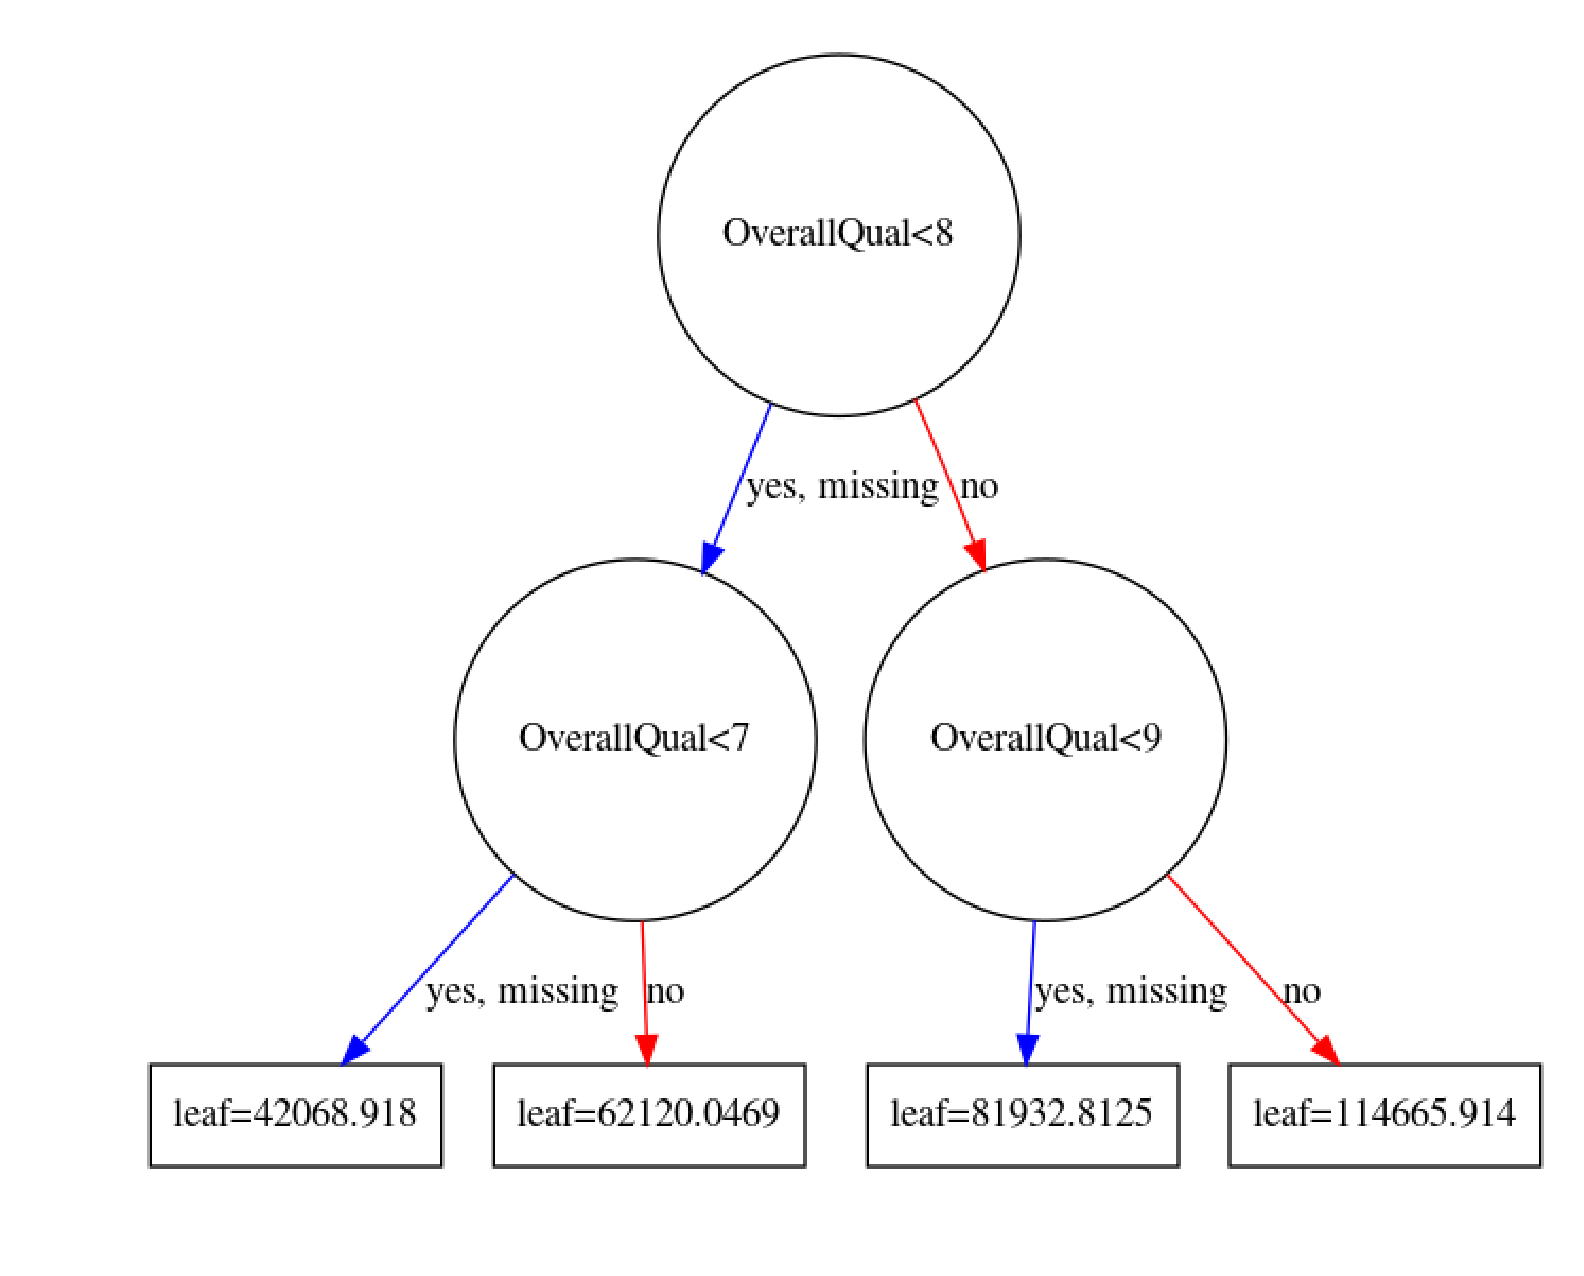

In [67]:
xgb.plot_tree(xg_reg, num_trees=0)
fig = plt.gcf()
fig.set_dpi(300)
fig.set_size_inches(10, 5)
plt.show()

Plot the fifth tree.

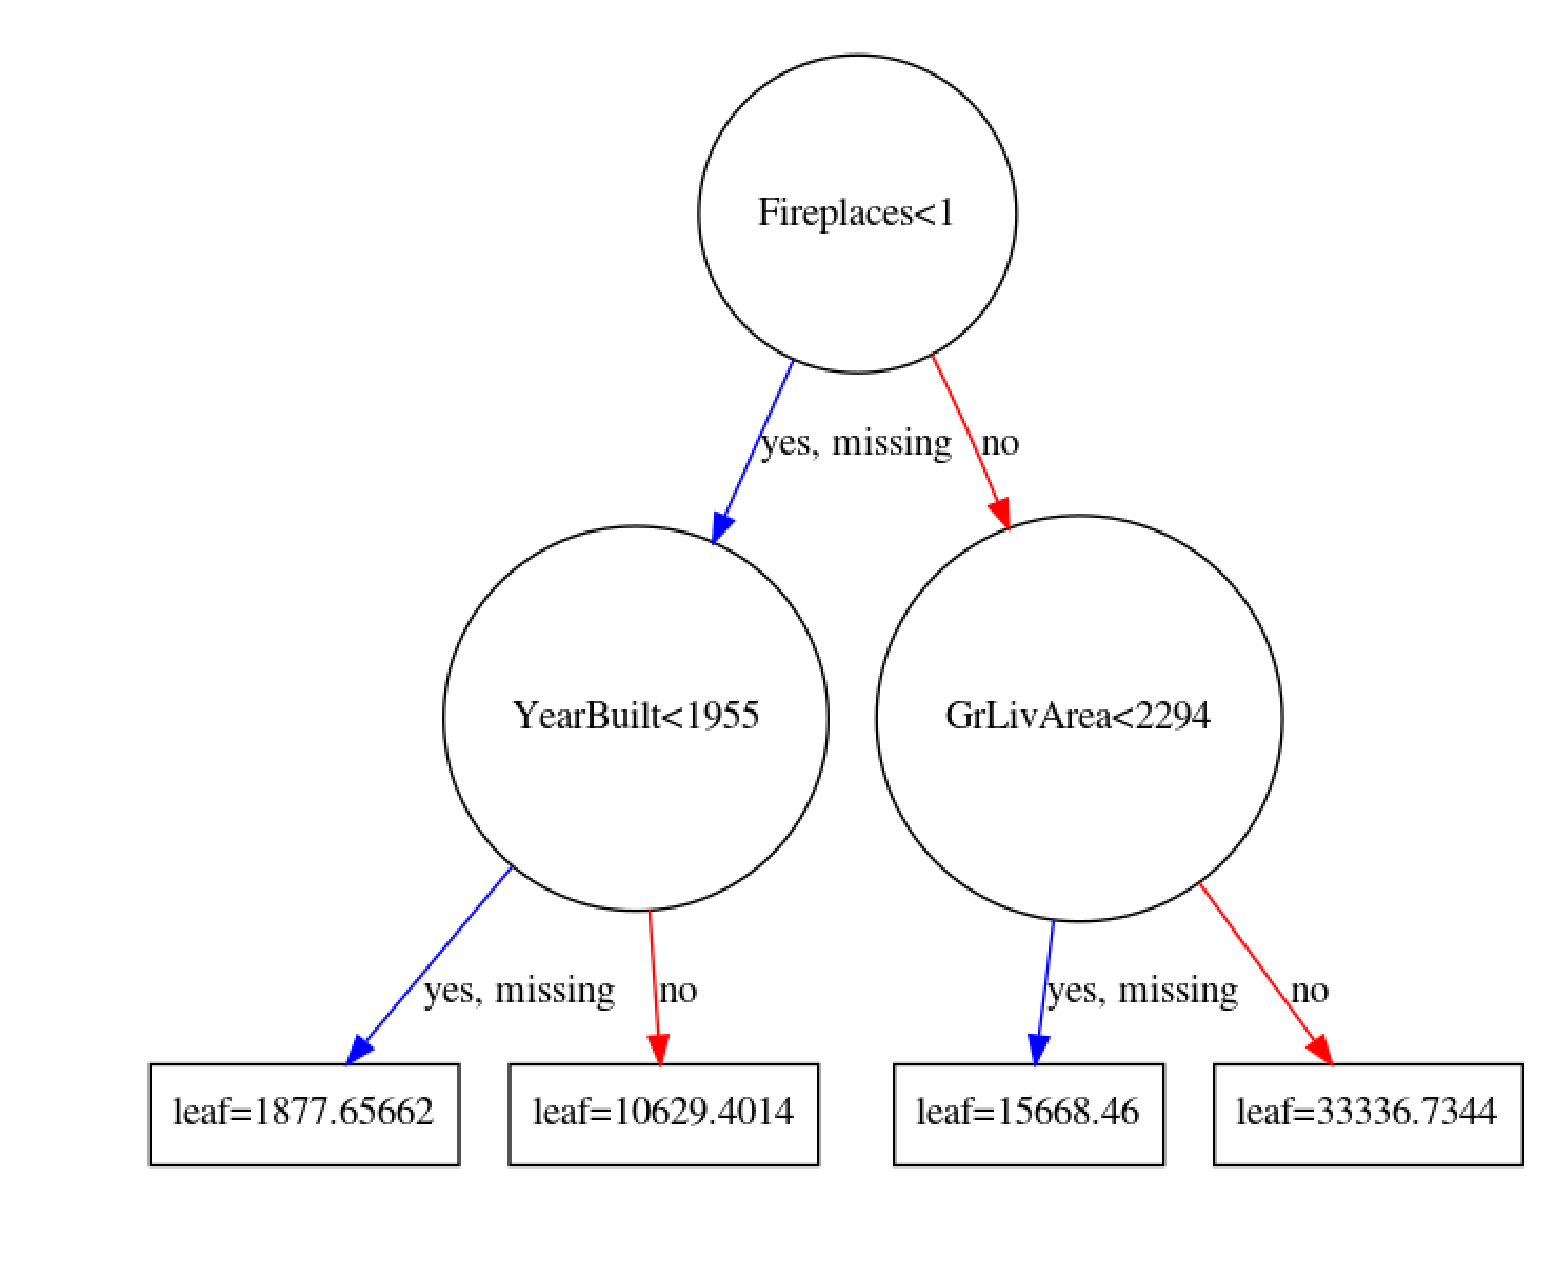

In [68]:
xgb.plot_tree(xg_reg, num_trees=4)
fig = plt.gcf()
fig.set_dpi(300)
fig.set_size_inches(10, 5)
plt.show()

Plot the last (tenth) tree sideways. To do this, specify the additional keyword argument rankdir="LR".

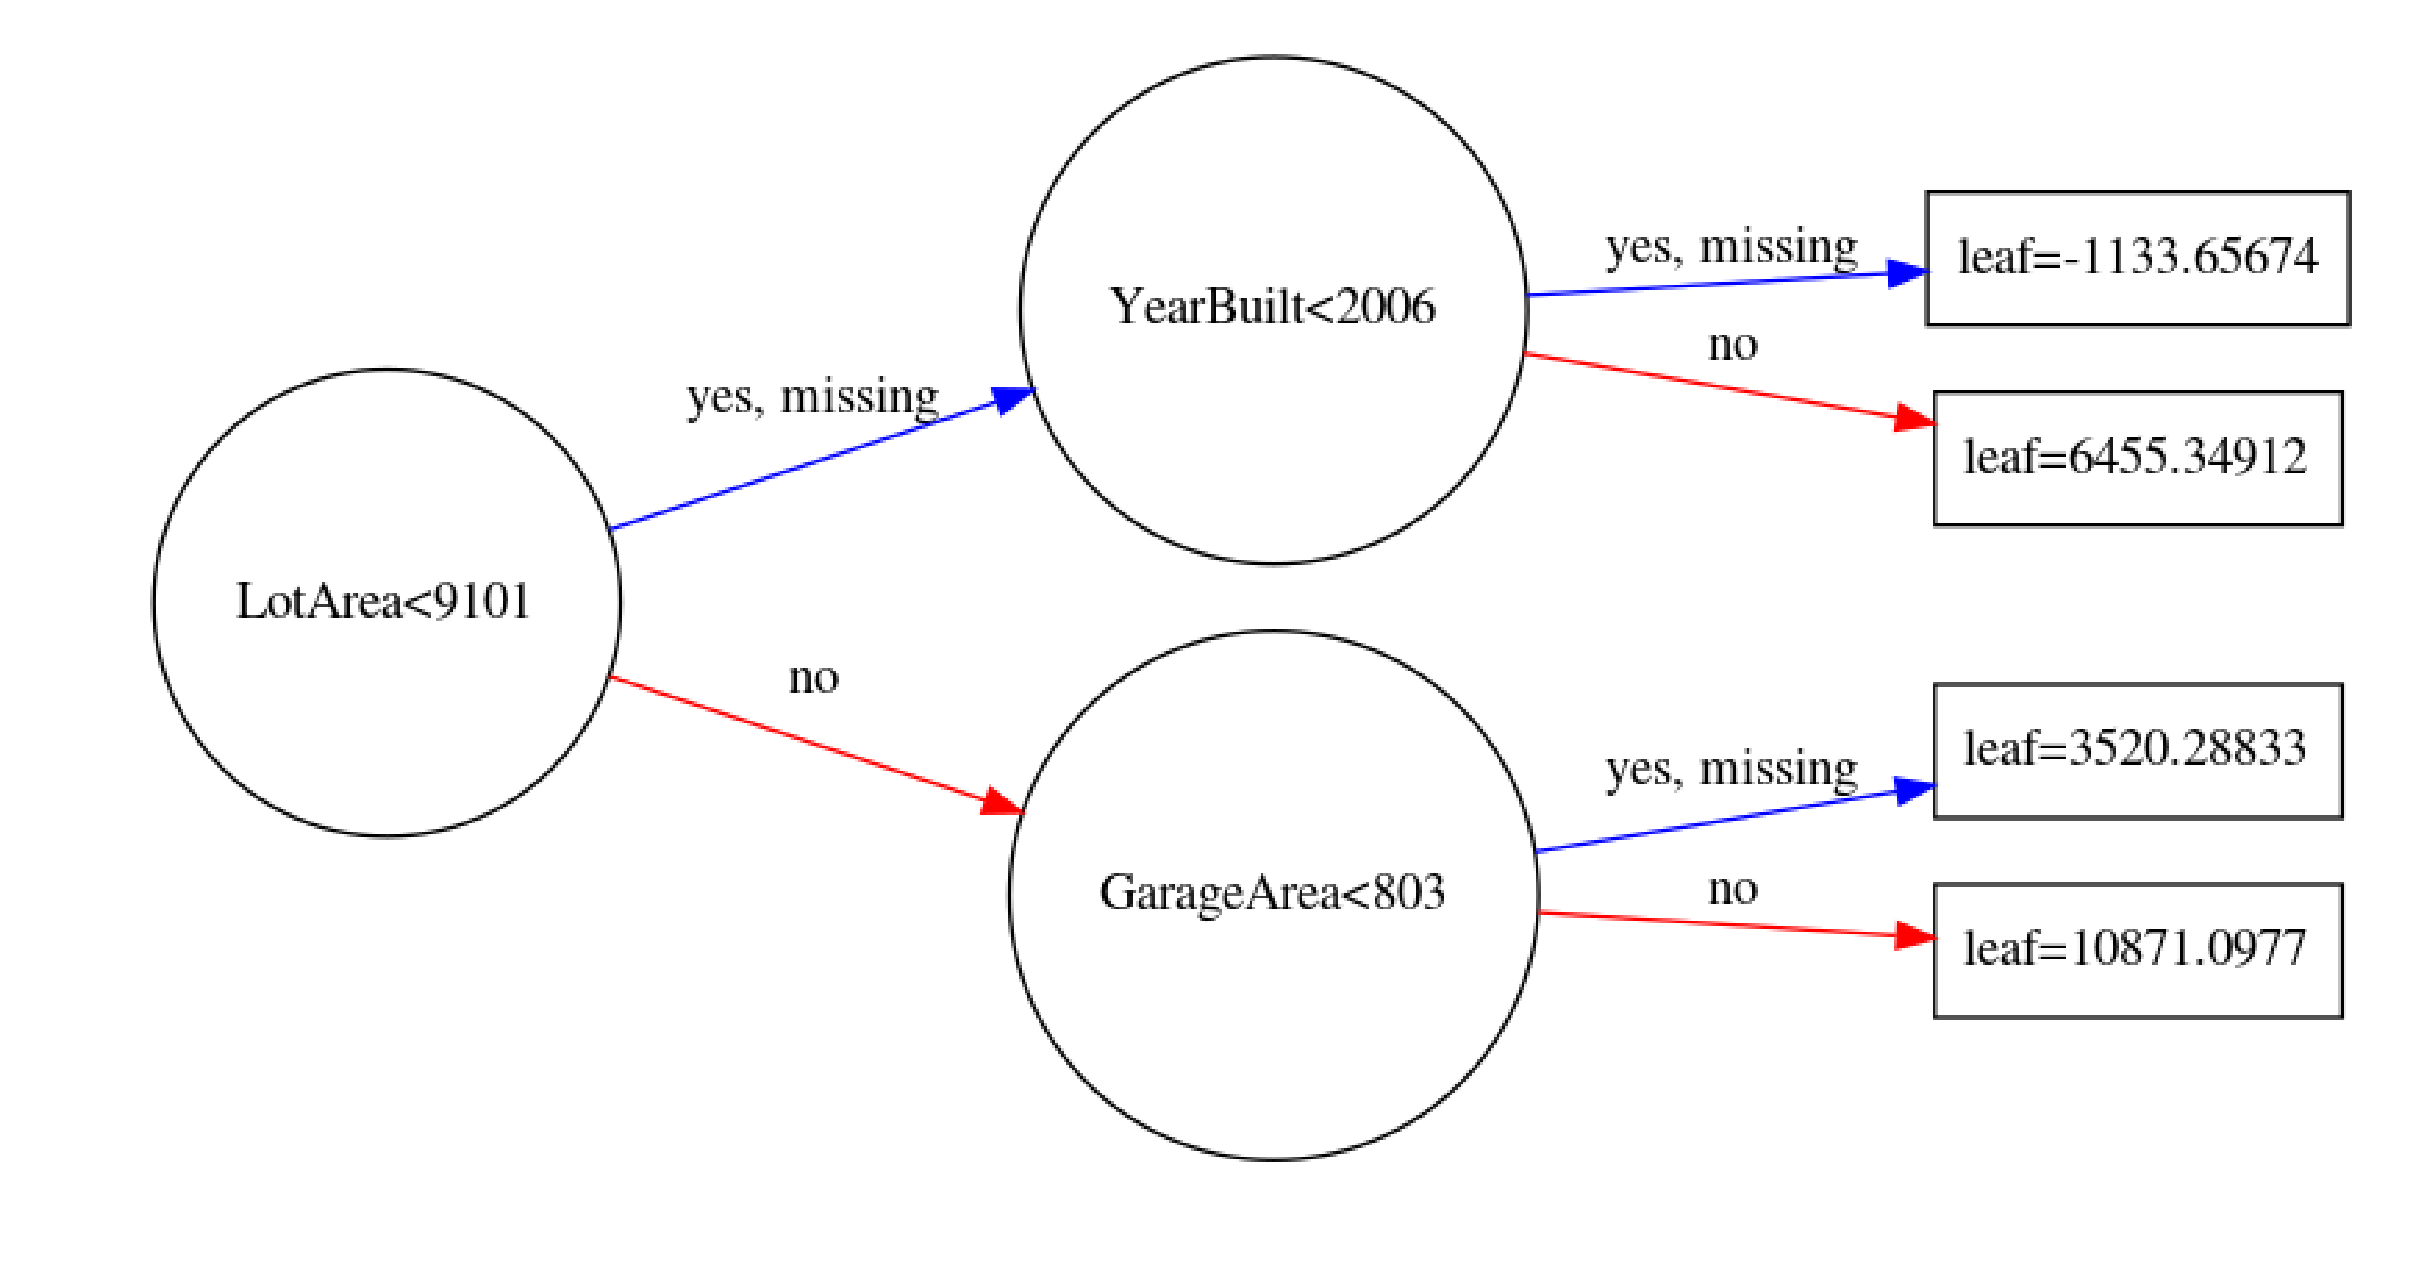

In [69]:
xgb.plot_tree(xg_reg, num_trees=9, rankdir="LR")
fig = plt.gcf()
fig.set_dpi(300)
fig.set_size_inches(10, 5)
plt.show()

<b /> 6. Visualizing feature importances: What features are most important in my dataset

Another way to visualize your XGBoost models is to examine the importance of each feature column in the original dataset within the model.

One simple way of doing this involves counting the number of times each feature is split on across all boosting rounds (trees) in the model, and then visualizing the result as a bar graph, with the features ordered according to how many times they appear. XGBoost has a plot_importance() function that allows you to do exactly this, and you'll get a chance to use it in this exercise!

You already have housing_dmatrix object <br />
Modify a parameter dictionary with an "objective" of "reg:linear" and a "max_depth" of 4

In [70]:
params = {'objective':'reg:linear', 'max_depth':4}

Train the model with 10 boosting rounds, exactly as you did in the previous exercise.

In [71]:
xg_reg = xgb.train(dtrain=housing_dmatrix, num_boost_round=10, params = params)

[01:43:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[01:43:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[01:43:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[01:43:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[01:43:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[01:43:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[01:43:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[01:43:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[01:43:26] /work

Use xgb.plot_importance() and pass in the trained model to generate the graph of feature importances.

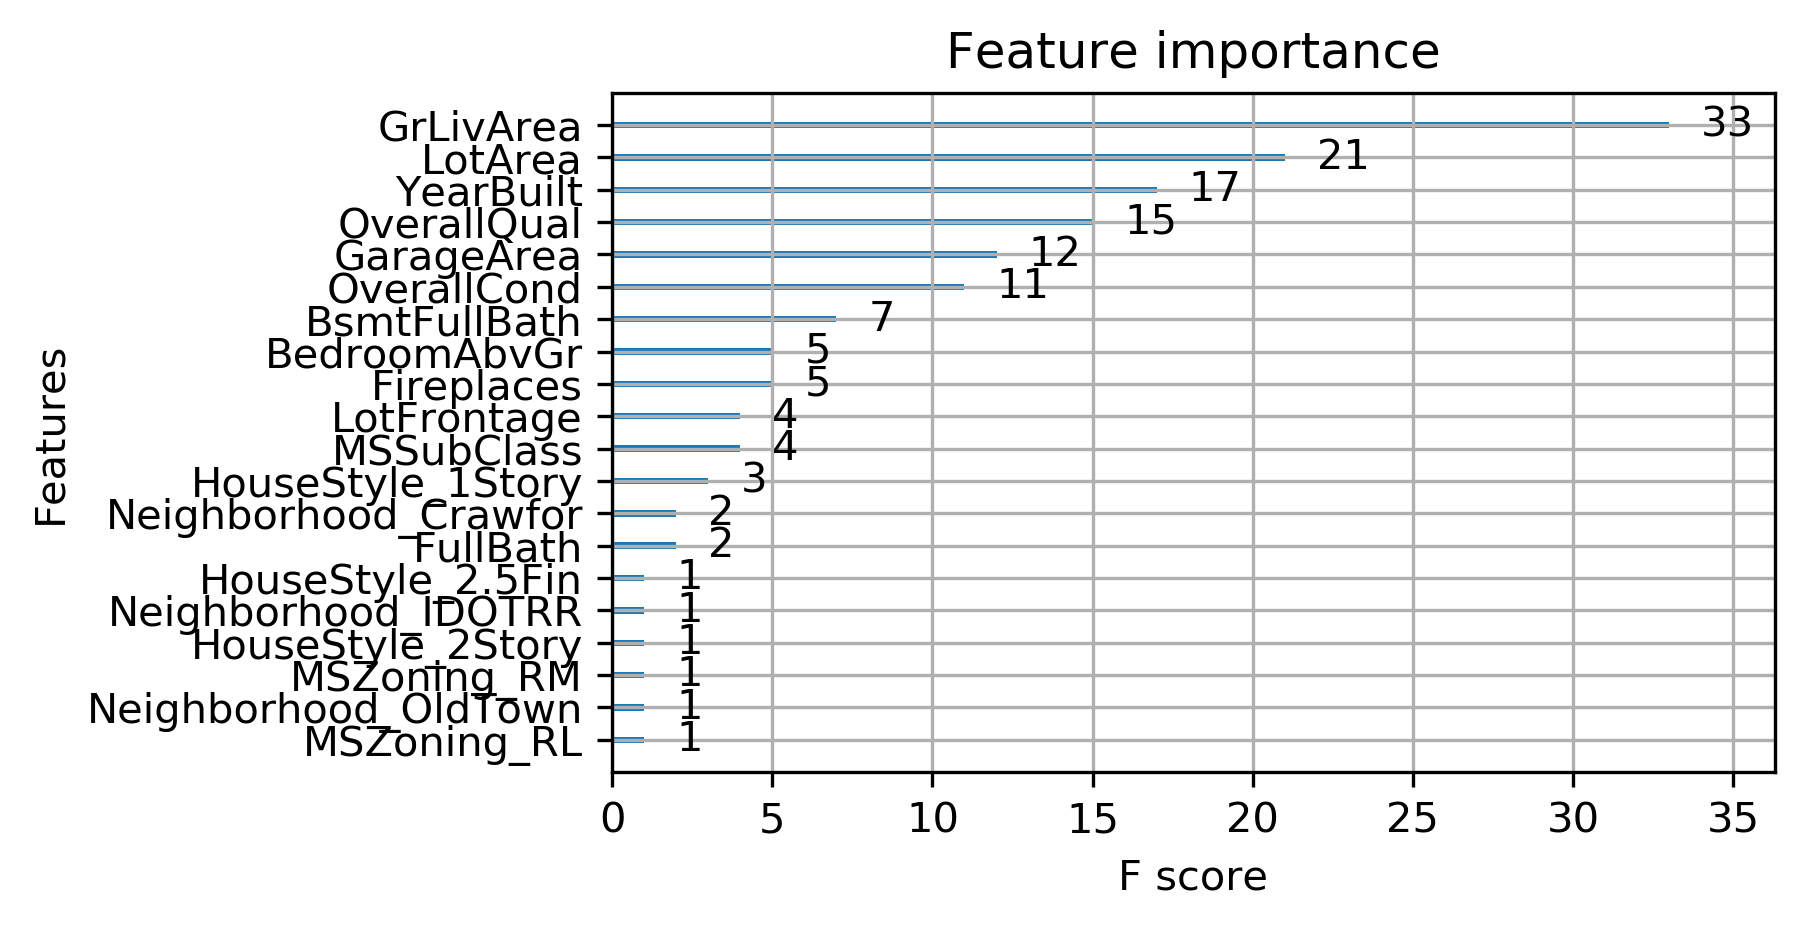

In [72]:
xgb.plot_importance(xg_reg)
fig = plt.gcf()
fig.set_dpi(300)
fig.set_size_inches(5, 3)
plt.show()